<a href="https://colab.research.google.com/github/hunubul/Sirtet/blob/master/TrainCNN_FlowOnMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from importlib.machinery import SourceFileLoader
methods = SourceFileLoader('methods', '/content/drive/My Drive/methods.py').load_module()

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import h5py

from methods import AverageSmooth
from methods import RMSE
from methods import CrossCorrelation
from methods import calcFurierTransform

In [0]:
'''
Parameters:
'''
wd = 200 # deepness of moving window in time 
wh = 64 # wertical and horizontal width of images at downscaling
color_channel = 1
rate_epoch_num = 1000 # Number of epochs in training of rates

# Definitions

In [0]:
'''
Load in signal from file
'''
def readFromFile(path,filename,signal):
  print("Load to from file:"+path+filename)
  print("...")
  print("loaded")
  with open(path+filename,"r") as ins:
    lines = ins.readlines()
    for line in lines:
      signal.append(float(line))
  return np.asarray(signal)

In [0]:
'''
save signal to file
'''
def saveToFile(path,filename,signal):
  print("Save to this file:"+path+filename)
  print("...")
  print("saved")
  with open(path+filename,"w") as o:
    for i in range(len(signal)):
      o.write(str(signal[i]))
      o.write("\n")

In [0]:
def loadSignalSet(path,set):
  ujset = []
  with open(path,'r') as ins:
    lines = ins.readlines()
    for line in lines:
      values = line.split(',')
      values = values[:-1] # At the end we have an extra ','
      row = []
      for val in values:
        row.append(float(val))
      ujset.append(row)
  return np.asarray(ujset)

# Load Data

In [173]:
'''
Load the calculated signal
'''
signal=[]
signal = loadSignalSet("output/MixedDataset2",signal)
print(signal.shape)

(159, 200)


In [174]:
'''
Load the calculated signal
'''
reference = []
reference = readFromFile("output/","MixedDataset_ref2",reference)
print(reference.shape)

Load to from file:output/MixedDataset_ref2
...
loaded
(159,)


# Build Network

Rate Head

In [0]:
tf.reset_default_graph()

In [0]:
'''
Initialization
'''

oneD_kernels = [1, 64, 64, 32, 16, 8]
oneD_win_sizes = [32, 32, 16, 8, 4]

batch_size = 1
leaning_rate = 1e-4

THRESHOLDING = False
AUGMENTATION = False
BATCH_NORM = False
DROPOUT = True
UNET = False
L2 = False

In [0]:
'''
Define placeholders
'''
input_data = tf.placeholder(tf.float32, [None, wd])
ref_rate = tf.placeholder(tf.float32, [None,1])

In [200]:
layer_num = 0

'''
1D convolutions. Shape it to the shape of expected output.
'''
current_input = tf.reshape(input_data,[batch_size,1,wd])
for i in range(len(oneD_kernels)-1):
  with tf.variable_scope("1d_conv_"+str(layer_num)):
    W = tf.get_variable('weight', [oneD_win_sizes[i],oneD_kernels[i],oneD_kernels[i+1]], trainable=True) 
    conv_result = tf.nn.conv1d(current_input, W, stride=[1], padding='SAME', data_format='NCW')
    B = tf.get_variable('bias', oneD_kernels[i+1], trainable=True)  
    
    act = tf.nn.elu(conv_result)
    current_input = act    
    pooled = tf.nn.avg_pool1d(current_input, ksize=[1,2,1], strides=[2], padding='SAME', data_format='NCW')

    print(pooled) 
    current_input = pooled
    layer_num = layer_num + 1

Tensor("1d_conv_0/AvgPool1D/Squeeze:0", shape=(1, 64, 100), dtype=float32)
Tensor("1d_conv_1/AvgPool1D/Squeeze:0", shape=(1, 64, 50), dtype=float32)
Tensor("1d_conv_2/AvgPool1D/Squeeze:0", shape=(1, 32, 25), dtype=float32)
Tensor("1d_conv_3/AvgPool1D/Squeeze:0", shape=(1, 16, 13), dtype=float32)
Tensor("1d_conv_4/AvgPool1D/Squeeze:0", shape=(1, 8, 7), dtype=float32)


In [201]:
with tf.variable_scope('fully-' + str(layer_num)):
  current_shape = current_input.get_shape()
  feature_length = int(current_shape[1] * current_shape[2])
  fully_connected = tf.reshape(current_input, [-1, feature_length])
  w = tf.get_variable('weight', [feature_length, 14])
  b = tf.get_variable('bias', [1])
  fully_connected = tf.matmul(fully_connected, w)
  fully_connected = tf.add(fully_connected,b, name = 'output')
  fully_connected = tf.nn.relu(fully_connected)
  if (DROPOUT == True):
      fully_connected = tf.nn.dropout(fully_connected, rate = 0.3)
  print(fully_connected)

  layer_num += 1

with tf.variable_scope('fully-' + str(layer_num)):
  w = tf.get_variable('weight', [14,7])
  b = tf.get_variable('bias', [7])
  fully_connected = tf.matmul(fully_connected,w)
  fully_connected = tf.add(fully_connected,b)
  fully_connected = tf.nn.relu(fully_connected)
  if (DROPOUT == True):
      fully_connected = tf.nn.dropout(fully_connected, rate = 0.3)
  print(fully_connected)

  layer_num += 1

with tf.variable_scope('fully-' + str(layer_num)):
  w = tf.get_variable('weight', [7,1])
  b = tf.get_variable('bias', [1])
  fully_connected = tf.matmul(fully_connected,w)
  fully_connected = tf.add(fully_connected,b)
  #fully_connected = tf.nn.relu(fully_connected)
  
  layer_num += 1

output = fully_connected
myrate = output

Tensor("fully-5/dropout/mul_1:0", shape=(1, 14), dtype=float32)
Tensor("fully-6/dropout/mul_1:0", shape=(1, 7), dtype=float32)


In [0]:
'''
Define loss function and optimizer
'''
with tf.variable_scope('loss'):
    loss = tf.reduce_mean(tf.losses.mean_squared_error(ref_rate, myrate))

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(leaning_rate).minimize(loss)

# Run Training

In [0]:
def mynorm(sig):
  avg = np.mean(sig)
  sig = sig - np.ones_like(sig)*avg
  sig = sig / np.max(sig)
  return sig

In [0]:
# 1204 + 1504                             + 1604

In [0]:
train_epoch_num = 1504
batch_size = 1
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()
indices = list(range(0,len(reference)))
#saver.restore(sess, "checkpoint/TrainCNN-FlowOnMix-1204")
loss_plot = np.zeros(train_epoch_num*int(len(indices)/batch_size))

In [0]:
step = 0
for epoch in range(train_epoch_num): 
    print("new epoch " + str(epoch))
     
    # create list of indices 
    indices = list(range(0,len(reference)))
    length = len(indices)
    
    avg_loss = 0
    while(batch_size<len(indices)):

        # Make batch of input data
        used_in_batch = random.sample(indices,batch_size)
        
        batch_x = []
        for i in used_in_batch:
          batch_x.append(mynorm(signal[i]))
        batch_x = np.asarray(batch_x)
        batch_x = np.reshape(batch_x, [batch_size, wd])

        batch_y = []
        for i in used_in_batch:
          batch_y.append(reference[i])
        batch_y = np.asarray(batch_y)
        batch_y = np.reshape(batch_y,[batch_size,1])

        _, l = sess.run([optimizer, loss], feed_dict={input_data: batch_x, ref_rate: batch_y})
        loss_plot[step] = l
            
        step = step + 1
        avg_loss = avg_loss + l
              
        for index in used_in_batch:
          indices.remove(index)
    print(avg_loss/length)
        
print('Saving model...')
print(saver.save(sess, "checkpoint/TrainCNN-FlowOnMix", train_epoch_num))
plt.plot(loss_plot[loss_plot!=0])

new epoch 0
2132.4455009796334
new epoch 1
2137.9378946172365
new epoch 2
2135.9885804758133
new epoch 3
2139.0611693184333
new epoch 4
2138.899405617384
new epoch 5
2118.705282919062
new epoch 6
2124.498896952695
new epoch 7
2119.2145673643868
new epoch 8
2122.0849983647186
new epoch 9
2108.681580933385
new epoch 10
2108.0862854771644
new epoch 11
2109.1767480238427
new epoch 12
2105.664172094573
new epoch 13
2103.1428547025475
new epoch 14
2097.1054328582572
new epoch 15
2098.149389878759
new epoch 16
2098.5585517163545
new epoch 17
2083.764122345163
new epoch 18
2078.277246439232
new epoch 19
2085.2408011574416
new epoch 20
2073.4028118781325
new epoch 21
2081.971306566922
new epoch 22
2083.549198366561
new epoch 23
2080.2448436809036
new epoch 24
2078.0234893223023
new epoch 25
2070.4235287072524
new epoch 26
2057.600281721391
new epoch 27
2063.1162980757417
new epoch 28
2051.9941001268303
new epoch 29
2047.8505638650379
new epoch 30
2053.000889808127
new epoch 31
2038.347690990136

# Demo

In [190]:
train_epoch_num = 1201
batch_size = 1
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()
indices = list(range(0,len(reference)))
saver.restore(sess, "checkpoint/TrainCNN-FlowOnMix-1503")
loss_plot = np.zeros(train_epoch_num*int(len(indices)/batch_size))

INFO:tensorflow:Restoring parameters from checkpoint/TrainCNN-FlowOnMix-1503


In [191]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#saver.restore(sess, "checkpoint/FreqNet4-1005")
saver.restore(sess, "checkpoint/TrainCNN-FlowOnMix-1503")

INFO:tensorflow:Restoring parameters from checkpoint/TrainCNN-FlowOnMix-1503


In [0]:
output_rates = []
#refs = []
for i in range(0,len(signal)):
  sig = np.asarray(mynorm(signal[i]))
  sig = np.reshape(sig, [1,wd])
  r = sess.run([myrate], feed_dict={input_data: sig})
  output_rates.append(r)

  #refs.append(np.mean(reference_train[i:i+wd]))

In [193]:
# absolute error
errors = []
for i in range(len(output_rates)):
  errors.append(abs(output_rates[i]-reference[i]))
print(np.mean(errors))

47.15587


In [194]:
output_rates = np.asarray(output_rates)
print(output_rates.shape)
print(reference[:300].shape)

(159, 1, 1, 1)
(159,)


In [0]:
output_rates = output_rates.flatten()

In [0]:
output_rates = np.reshape(output_rates, [len(output_rates)])

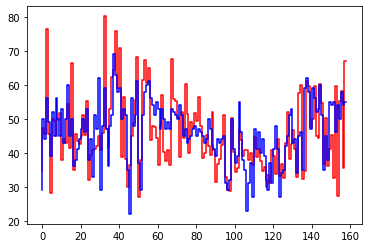

In [165]:
plt.step(output_rates,'r')
plt.step(reference,'b')